In [49]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm
import tqdm

In [50]:
# ticker_symbol = "AAPL" 
# options_chain = get_options_chain(ticker_symbol)

# first_expiration_date = list(options_chain.keys())[0]
# print(f"Options chain for {ticker_symbol} on {first_expiration_date}:")
# print("Calls:")
# print(options_chain[first_expiration_date]['calls'])
# print("\nPuts:")
# print(options_chain[first_expiration_date]['puts'])


In [51]:
data=pd.read_excel("Stock List.xlsx")
remove_stock=['LSDI', 'EVBG', 'AKLI', 'WIRE', 'PWFL', 'VERY', 'CVLY', 'TNP']
data=data[~data['Ticker'].isin(remove_stock)] 
All_Tickers=data.Ticker.to_list()
All_Tickers = [ticker for ticker in All_Tickers if isinstance(ticker, str)]

In [52]:
All_Tickers[:4000]

['AAPL',
 'MSFT',
 'NVDA',
 'GOOG',
 'AMZN',
 'META',
 'TSM',
 'LLY',
 'TSLA',
 'AVGO',
 'JPM',
 'WMT',
 'NVO',
 'UNH',
 'V',
 'XOM',
 'MA',
 'PG',
 'JNJ',
 'ORCL',
 'COST',
 'HD',
 'ABBV',
 'ASML',
 'BAC',
 'KO',
 'MRK',
 'NFLX',
 'AZN',
 'CVX',
 'ADBE',
 'SAP',
 'PEP',
 'TM',
 'NVS',
 'CRM',
 'TMO',
 'TMUS',
 'AMD',
 'LIN',
 'ACN',
 'SHEL',
 'MCD',
 'CSCO',
 'BABA',
 'ABT',
 'PM',
 'WFC',
 'DHR',
 'IBM',
 'FMX',
 'TXN',
 'QCOM',
 'AXP',
 'GE',
 'AMGN',
 'INTU',
 'NOW',
 'RY',
 'ISRG',
 'NEE',
 'UL',
 'SPGI',
 'CAT',
 'PFE',
 'DIS',
 'HSBC',
 'MS',
 'RTX',
 'TTE',
 'HDB',
 'UNP',
 'GS',
 'CMCSA',
 'UBER',
 'AMAT',
 'T',
 'SNY',
 'PGR',
 'LOW',
 'SYK',
 'LMT',
 'BHP',
 'TJX',
 'HON',
 'BLK',
 'ARM',
 'PDD',
 'REGN',
 'BKNG',
 'ELV',
 'COP',
 'BUD',
 'MUFG',
 'NKE',
 'VRTX',
 'BSX',
 'PLD',
 'SCHW',
 'CB',
 'C',
 'MDT',
 'SONY',
 'ETN',
 'MMC',
 'PANW',
 'ADP',
 'ADI',
 'UPS',
 'AMT',
 'KKR',
 'TD',
 'DE',
 'SBUX',
 'IBN',
 'MELI',
 'ANET',
 'HCA',
 'BMY',
 'MDLZ',
 'BX',
 'BA',
 'MU',


In [111]:
# prices_data = yf.download(All_Tickers[:4000], start='2024-01-01')
prices_data = yf.download(All_Tickers[:4000], start='2024-07-01')


[*********************100%%**********************]  4000 of 4000 completed

14 Failed downloads:
['HOLI', 'WRK', 'MCBC', 'ETRN', 'OSG', 'SLCA', 'OLK', 'CALB', 'CERE', 'NWLI', 'SMLP', 'SBOW', 'HIBB', 'JAN']: YFChartError('%ticker%: No data found, symbol may be delisted')


In [112]:
def gkyz_volatility(data):
    """
    Calculate the Garman-Klass-Yang-Zhang (GKYZ) volatility estimator.

    Parameters:
    - data: A DataFrame containing the columns 'Open', 'High', 'Low', and 'Close'.

    Returns:
    - GKYZ Volatility (annualized).
    """
    
    # Calculate the log returns
    log_high_low = np.log(data['High'] / data['Low'])**2
    log_close_open = np.log(data['Adj Close'] / data['Open'])**2
    log_close_yesterday = np.log(data['Adj Close'] / data['Adj Close'].shift(1))**2

    sigma_hl = (log_high_low / (4 * np.log(2))).mean()
    sigma_oc = (log_close_open * 0.5).mean()
    sigma_cc = log_close_yesterday.mean()

    # GKYZ Volatility calculation
    gkyz_var = 0.5 * sigma_hl + (2 * np.log(2) - 1) * sigma_cc + sigma_oc
    gkyz_volatility = np.sqrt(gkyz_var)

    # Annualize the volatility assuming 252 trading days per year
    annualized_volatility = gkyz_volatility * np.sqrt(252)
    
    return annualized_volatility

In [113]:
def calculate_rsi(data, window=14):
    """
    Calculate the Relative Strength Index (RSI) for a given data set.

    Parameters:
    - data: A DataFrame or Series of closing prices.
    - window: The number of periods to use in the calculation (default is 14).

    Returns:
    - A Pandas Series representing the RSI values.
    """
    
    # Calculate the price differences
    delta = data.diff()
    
    # Separate the gains and losses
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    
    # Calculate the rolling averages
    avg_gain = pd.Series(gain).rolling(window=window, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=window, min_periods=1).mean()
    
    # Calculate the RS (Relative Strength)
    rs = avg_gain / avg_loss
    
    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))
    
    return pd.Series(rsi, name='RSI')

In [114]:
volatility_results = {}

for ticker in  tqdm.tqdm(prices_data.columns.levels[1]):
    # Extract the data for the current ticker
    ticker_data = prices_data.xs(ticker, level='Ticker', axis=1).dropna()

    if ticker_data.empty:
        pass
    else:

        total_change = ticker_data['Adj Close'][-1] / ticker_data['Adj Close'].iloc[0]
        
        # Calculate the RSI
        rsi = calculate_rsi(ticker_data['Adj Close'], window=14)
        # and rsi.iloc[-1] > 60
        # Check conditions for significant price change, volume, and RSI
        if total_change > 0.5 and ticker_data['Volume'][-30:].mean() >= 1000000 and ticker_data['Volume'][-30:].mean()<ticker_data['Volume'][-5:].mean():
            # Calculate the GKYZ volatility
            volatility = gkyz_volatility(ticker_data)
            
            # Store the volatility along with the open price in the results dictionary
            volatility_results[ticker] = {
                'Volatility': volatility,
                'Adj Close': ticker_data['Adj Close'].iloc[-1]
            }

# Convert the results to a DataFrame for easier viewing
volatility_df = pd.DataFrame(volatility_results).T

  0%|          | 0/4000 [00:00<?, ?it/s]C:\Users\adnan\AppData\Local\Temp\ipykernel_19424\2486766410.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_change = ticker_data['Adj Close'][-1] / ticker_data['Adj Close'].iloc[0]
 16%|█▌        | 626/4000 [00:00<00:05, 670.21it/s]C:\Users\adnan\AppData\Local\Temp\ipykernel_19424\2486766410.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_change = ticker_data['Adj Close'][-1] / ticker_data['Adj Close'].iloc[0]
 17%|█▋        | 694/4000 [00:01<00:04, 669.68it/s]C:\Users\adnan\AppData\Local\Temp\ipykernel_19424\2486766410.py:11: FutureWarning: Series.__geti

In [115]:
volatility_df=volatility_df.sort_values(by='Volatility',ascending=False)
volatility_df

,Volatility,Adj Close
NNE,2.070782,19.389999
UXIN,1.951670,7.350000
PEV,1.916909,1.070000
EAF,1.592150,1.620000
CAPR,1.428994,21.650000
...,...,...
IBN,0.142533,29.410000
JNPR,0.089618,38.820000
AAN,0.072238,10.090000
SQSP,0.065328,46.490002


In [116]:
def get_options_chain(ticker_symbol, strike,type='calls',date='2024-10-11'):
    ticker = yf.Ticker(ticker_symbol)
    
    # Get available expiration dates
    expiration_dates = ticker.options
    options_chain = {}
    
    if not expiration_dates:
        return None    
    for expiration_date in expiration_dates:
        options_chain_data = ticker.option_chain(expiration_date)
        options_chain[expiration_date] = {
            'calls': options_chain_data.calls,
            'puts': options_chain_data.puts
        }
    
    if date in options_chain:
        options_chain_df = options_chain[date][type][['strike', 'bid', 'ask', 'impliedVolatility']]
    else:
        return None

    if strike in options_chain_df['strike'].unique():
        options_chain_df = options_chain_df[options_chain_df['strike'] == strike]
    else:
        try:
            # Calculate the closest strike
            sorted_strikes = (options_chain_df['strike'] - strike).abs().argsort()[:1]
            
            # Check if there are any strikes available after sorting
            if not sorted_strikes.empty:
                closest_strike = options_chain_df['strike'].iloc[sorted_strikes].values[0]
                options_chain_df = options_chain_df[options_chain_df['strike'] == closest_strike]
            else:
                # Handle the case where no strike prices are found
                print("No matching strikes found in the DataFrame.")
        except KeyError:
            pass
    return options_chain_df

def black_scholes(S, K, T, r, sigma, option_type='call'):
    """
    Calculate the Black-Scholes option price.

    Parameters:
    - S: Current stock price
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate (annualized)
    - sigma: Volatility of the underlying asset (annualized)
    - option_type: 'call' or 'put'

    Returns:
    - Option price
    """
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be either 'call' or 'put'")
    
    return option_price


In [117]:
for ticker in tqdm.tqdm(volatility_df.index):
    open_price = np.round(volatility_df.at[ticker, 'Adj Close'],0)
    try:
        # options_data_call_forward = get_options_chain(ticker, open_price,type='calls',date='2024-10-11')
        # options_data_put_forward = get_options_chain(ticker, open_price,type='puts',date='2024-10-11')
        options_data_call_early = get_options_chain(ticker, open_price,type='calls',date='2024-10-11')
        options_data_put_early = get_options_chain(ticker, open_price,type='puts',date='2024-10-11')
    
        # if options_data_call_early is not None and not options_data_call_early.empty and options_data_put_early is not None and not options_data_put_early.empty and options_data_call_forward is not None and not options_data_call_forward.empty and options_data_put_forward is not None and not options_data_put_forward.empty:
        if options_data_call_early is not None and not options_data_call_early.empty and options_data_put_early is not None and not options_data_put_early.empty:
        
            # volatility_df.at[ticker, 'Option Strike_call_forward'] = options_data_call_forward['strike'].values[0]
            # volatility_df.at[ticker, 'Option Bid_call_forward'] = options_data_call_forward['bid'].values[0]
            # volatility_df.at[ticker, 'Option Ask_call_forward'] = options_data_call_forward['ask'].values[0]
            # volatility_df.at[ticker, 'Implied Volatility_call_forward'] = options_data_call_forward['impliedVolatility'].values[0]
            # volatility_df.at[ticker, 'Option Strike_put_forward'] = options_data_put_forward['strike'].values[0]
            # volatility_df.at[ticker, 'Option Bid_put_forward'] = options_data_put_forward['bid'].values[0]
            # volatility_df.at[ticker, 'Option Ask_put_forward'] = options_data_put_forward['ask'].values[0]
            # volatility_df.at[ticker, 'Implied Volatility_put_forward'] = options_data_put_forward['impliedVolatility'].values[0]

            volatility_df.at[ticker, 'Option Strike_call_early'] = options_data_call_early['strike'].values[0]
            volatility_df.at[ticker, 'Option Bid_call_early'] = options_data_call_early['bid'].values[0]
            volatility_df.at[ticker, 'Option Ask_call_early'] = options_data_call_early['ask'].values[0]
            volatility_df.at[ticker, 'Implied Volatility_call_early'] = options_data_call_early['impliedVolatility'].values[0]
            volatility_df.at[ticker, 'Option Strike_put_early'] = options_data_put_early['strike'].values[0]
            volatility_df.at[ticker, 'Option Bid_put_early'] = options_data_put_early['bid'].values[0]
            volatility_df.at[ticker, 'Option Ask_put_early'] = options_data_put_early['ask'].values[0]
            volatility_df.at[ticker, 'Implied Volatility_put_early'] = options_data_put_early['impliedVolatility'].values[0]
    except:
        pass

# Display the updated DataFrame
print(volatility_df)

 51%|█████     | 225/442 [03:38<04:38,  1.28s/it]

No matching strikes found in the DataFrame.


 70%|███████   | 310/442 [05:11<02:28,  1.12s/it]

No matching strikes found in the DataFrame.


 82%|████████▏ | 364/442 [06:04<01:22,  1.05s/it]

No matching strikes found in the DataFrame.


100%|██████████| 442/442 [07:15<00:00,  1.02it/s]

      Volatility  Adj Close  Option Strike_call_early  Option Bid_call_early  \
NNE     2.070782  19.389999                       NaN                    NaN   
UXIN    1.951670   7.350000                       NaN                    NaN   
PEV     1.916909   1.070000                       NaN                    NaN   
EAF     1.592150   1.620000                       NaN                    NaN   
CAPR    1.428994  21.650000                       NaN                    NaN   
...          ...        ...                       ...                    ...   
IBN     0.142533  29.410000                       NaN                    NaN   
JNPR    0.089618  38.820000                       NaN                    NaN   
AAN     0.072238  10.090000                       NaN                    NaN   
SQSP    0.065328  46.490002                       NaN                    NaN   
PWSC    0.027076  22.809999                       NaN                    NaN   

      Option Ask_call_early  Implied Vo

In [118]:
options_data_call_early = get_options_chain('BBVA', np.round(volatility_df.at['BBVA', 'Adj Close'],0),type='calls',date='2024-10-11')
print(options_data_call_early)

None


In [119]:
option_data=volatility_df.copy()

In [120]:
for ticker in  tqdm.tqdm(option_data.index.unique()):
    try:

        option_data.at[ticker, 'BS_Valuation_call_early'] = black_scholes(option_data[option_data.index==ticker]['Adj Close'].values[0],option_data[option_data.index==ticker]['Option Strike_call_early'].values[0],10/365,4.19/100,option_data[option_data.index==ticker]['Volatility'].values[0])
        option_data.at[ticker, 'BS_Valuation_put_early'] = black_scholes(option_data[option_data.index==ticker]['Adj Close'].values[0],option_data[option_data.index==ticker]['Option Strike_put_early'].values[0],10/365,4.19/100,option_data[option_data.index==ticker]['Volatility'].values[0],'put')
        # option_data.at[ticker, 'BS_Valuation_call_forward'] = black_scholes(option_data[option_data.index==ticker]['Adj Close'].values[0],option_data[option_data.index==ticker]['Option Strike_call_forward'].values[0],17/365,4.19/100,option_data[option_data.index==ticker]['Volatility'].values[0])
        # option_data.at[ticker, 'BS_Valuation_put_forward'] = black_scholes(option_data[option_data.index==ticker]['Adj Close'].values[0],option_data[option_data.index==ticker]['Option Strike_put_forward'].values[0],17/365,4.19/100,option_data[option_data.index==ticker]['Volatility'].values[0],'put')
        # option_data.at[ticker, 'BS_Valuation_CallSpread'] = option_data.at[ticker, 'BS_Valuation_call_forward']-option_data.at[ticker, 'BS_Valuation_call_early']
        option_data.at[ticker, 'BS_Valuation_PutSpread'] =  option_data.at[ticker, 'BS_Valuation_put_forward']-option_data.at[ticker, 'BS_Valuation_put_early']
    #     option_data.at[ticker, 'Actual_CallSpread'] = (option_data.at[ticker, 'Option Bid_call_forward']+option_data.at[ticker, 'Option Ask_call_forward'])/2-(option_data.at[ticker, 'Option Bid_call_early']+option_data.at[ticker, 'Option Ask_call_early'])/2
    #     option_data.at[ticker, 'Actual_PutSpread'] = (option_data.at[ticker, 'Option Bid_put_forward']+option_data.at[ticker, 'Option Ask_put_forward'])/2-(option_data.at[ticker, 'Option Bid_put_early']+option_data.at[ticker, 'Option Ask_put_early'])/2
    except:
        pass
option_data=np.round(option_data,4)

100%|██████████| 442/442 [00:00<00:00, 792.48it/s]


In [121]:
# option_data['Delta_call']=(option_data['Actual_CallSpread']-option_data['BS_Valuation_CallSpread'])
# option_data['Delta_put']=(option_data['Actual_PutSpread']-option_data['BS_Valuation_PutSpread'])
option_data['Max_UP_IV']=option_data['Adj Close']*option_data['Implied Volatility_call_early']*np.sqrt(11/365)+option_data['Adj Close']
option_data['Max_down_IV']=option_data['Adj Close']-option_data['Adj Close']*option_data['Implied Volatility_call_early']*np.sqrt(11/365)
option_data['Max_UP_AA']=option_data['Adj Close']*option_data['Volatility']*np.sqrt(11/365)+option_data['Adj Close']
option_data['Max_down_AA']=option_data['Adj Close']-option_data['Adj Close']*option_data['Volatility']*np.sqrt(11/365)
option_data['Call IV Delta']=option_data['Volatility']-option_data['Implied Volatility_call_early']
option_data['PUT IV Delta']=option_data['Volatility']-option_data['Implied Volatility_put_early']




In [122]:
# option_data=option_data.sort_values(by='Delta_put',ascending=False)

In [130]:
review=option_data[(option_data['Call IV Delta'] < -0.2) ]
review=review[(review['Implied Volatility_call_early']!=0) & (review['Implied Volatility_put_early']!=0)]
# review=review[review['Option Strike_call_early']==review['Option Strike_put_early']]
# review=review[review['Implied Volatility_call_early']/review['Implied Volatility_put_early']>=1]
review.sort_values(by='Call IV Delta',ascending=True)

,Volatility,Adj Close,Option Strike_call_early,Option Bid_call_early,Option Ask_call_early,Implied Volatility_call_early,Option Strike_put_early,Option Bid_put_early,Option Ask_put_early,Implied Volatility_put_early,BS_Valuation_call_early,BS_Valuation_put_early,Max_UP_IV,Max_down_IV,Max_UP_AA,Max_down_AA,Call IV Delta,PUT IV Delta
TLRY,0.5445,1.690,2.0,0.04,0.05,1.6250,2.0,0.34,0.37,1.6250,0.0020,0.3098,2.166749,1.213251,1.849748,1.530252,-1.0805,-1.0805
FCEL,1.0931,0.350,0.5,0.00,0.01,1.8750,0.5,0.12,0.19,2.2500,0.0007,0.1501,0.463925,0.236075,0.416417,0.283583,-0.7819,-1.1569
BB,0.4736,2.360,2.0,0.37,0.40,1.2188,2.0,0.00,0.01,0.8125,0.3633,0.0010,2.859338,1.860662,2.554032,2.165968,-0.7452,-0.3389
BILI,0.7263,27.570,27.0,2.39,2.43,1.4043,25.0,0.83,0.99,1.3311,1.6293,0.3633,34.291196,20.848804,31.046184,24.093816,-0.6780,-0.6048
BEKE,0.6502,25.800,25.5,1.62,1.91,1.2285,25.0,0.95,1.50,1.2275,1.2725,0.7247,31.302306,20.297694,28.712169,22.887831,-0.5783,-0.5773
CPRI,0.3908,42.280,42.0,0.50,3.80,0.9316,40.0,0.00,3.00,1.1777,1.2585,0.2794,49.117768,35.442232,45.148398,39.411602,-0.5408,-0.7869
RBLX,0.3976,41.990,42.0,1.54,2.38,0.9150,42.0,1.49,3.65,1.1953,1.1210,1.0828,48.659862,35.320138,44.888292,39.091708,-0.5174,-0.7977
JD,0.4766,46.970,47.0,2.33,2.40,0.9912,46.0,1.80,1.87,0.9629,1.4895,1.0069,55.052240,38.887760,50.856194,43.083806,-0.5146,-0.4863
EQT,0.3369,36.940,37.0,0.25,2.78,0.8174,37.0,0.61,2.71,0.8623,0.8132,0.8307,42.181812,31.698188,39.100468,34.779532,-0.4805,-0.5254
FUTU,0.6873,127.980,110.0,19.50,19.95,1.1548,90.0,0.16,0.30,1.3496,18.6682,0.0032,153.636582,102.323418,143.249976,112.710024,-0.4675,-0.6623


In [28]:
review=option_data[(option_data.Delta_put > 1) | (option_data.Delta_put < -1)]
review

,Volatility,Adj Close,Option Strike_call_forward,Option Bid_call_forward,Option Ask_call_forward,Implied Volatility_call_forward,Option Strike_put_forward,Option Bid_put_forward,Option Ask_put_forward,Implied Volatility_put_forward,...,BS_Valuation_CallSpread,BS_Valuation_PutSpread,Actual_CallSpread,Actual_PutSpread,Delta_call,Delta_put,Max_UP_IV,Max_down_IV,Max_UP_AA,Max_down_AA
CVX,0.2114,150.650,150.0,2.84,2.89,0.2406,150.0,1.80,1.86,0.2315,...,0.6965,0.5762,-0.710,-0.550,-1.4065,-1.1262,156.924069,144.375931,156.178713,145.121287
FI,0.1864,182.285,182.5,2.05,2.25,0.1896,182.5,2.10,2.25,0.1838,...,0.7542,1.6537,-0.750,0.350,-1.5042,-1.3037,188.395590,176.174410,188.183570,176.386430
APO,0.3236,133.605,135.0,1.90,2.00,0.3413,130.0,1.05,1.15,0.2586,...,0.9083,0.7301,-0.850,-0.700,-1.7583,-1.4301,141.446837,125.763163,141.110526,126.099474
HSY,0.2431,193.070,192.5,3.10,3.40,0.2302,192.5,2.25,2.55,0.2334,...,1.0166,0.8622,-0.850,-0.625,-1.8666,-1.4872,200.611317,185.528683,201.217975,184.922025
BIIB,0.2843,188.690,190.0,2.50,2.85,0.2754,190.0,3.80,4.30,0.2908,...,1.1417,0.9893,-0.925,-0.750,-2.0667,-1.7393,197.534282,179.845718,198.002701,179.377299
FANG,0.2844,180.910,180.0,4.30,4.60,0.3287,180.0,3.20,3.40,0.3364,...,1.0985,0.9541,-0.950,-0.850,-2.0485,-1.8041,190.658419,171.161581,189.841863,171.978137
NTES,0.3321,103.640,105.0,3.10,3.30,0.5151,97.0,1.05,1.15,0.5471,...,0.7177,-2.3034,-0.850,-4.150,-1.5677,-1.8466,112.553193,94.726807,109.615114,97.664886
FUTU,0.5383,112.470,110.0,9.60,10.00,1.1714,90.0,0.73,0.84,1.0322,...,1.2171,0.0178,-1.925,-1.865,-3.1421,-1.8828,133.978520,90.961480,122.980200,101.959800
MPC,0.3213,164.350,165.0,3.10,3.25,0.2788,165.0,3.70,3.90,0.3761,...,1.1219,0.9895,-1.025,-0.975,-2.1469,-1.9645,172.458559,156.241441,173.517066,155.182934
BA,0.3649,153.290,152.5,4.45,4.65,0.4412,152.5,3.40,3.50,0.3667,...,1.1769,1.0545,-1.200,-1.100,-2.3769,-2.1545,164.623691,141.956309,163.000411,143.579589


In [ ]:
review.keys()

Index(['Volatility', 'Adj Close', 'Option Strike_call_forward',
       'Option Bid_call_forward', 'Option Ask_call_forward',
       'Implied Volatility_call_forward', 'Option Strike_put_forward',
       'Option Bid_put_forward', 'Option Ask_put_forward',
       'Implied Volatility_put_forward', 'Option Strike_call_early',
       'Option Bid_call_early', 'Option Ask_call_early',
       'Implied Volatility_call_early', 'Option Strike_put_early',
       'Option Bid_put_early', 'Option Ask_put_early',
       'Implied Volatility_put_early', 'BS_Valuation_call_early',
       'BS_Valuation_put_early', 'BS_Valuation_call_forward',
       'BS_Valuation_put_forward', 'BS_Valuation_CallSpread',
       'BS_Valuation_PutSpread', 'Actual_CallSpread', 'Actual_PutSpread',
       'Delta_call', 'Delta_put', 'Max_Move', 'Max_UP', 'Max_down',
       'Max_UP_IV', 'Max_down_IV', 'Max_UP_AA', 'Max_down_AA',
       'Call_Forward_Mid', 'Call_early_Mid', 'Put_Forward_Mid',
       'Put_early_Mid'],
      dtype='

In [30]:
view=review[['Volatility','Implied Volatility_call_early','Implied Volatility_call_forward', 'Adj Close','Option Strike_call_early','Option Strike_call_forward','BS_Valuation_CallSpread',
       'BS_Valuation_PutSpread', 'Actual_CallSpread', 'Actual_PutSpread',
       'Max_UP_IV', 'Max_down_IV', 'Max_UP_AA', 'Max_down_AA' ]]

In [31]:
view[view['Option Strike_call_early']==view['Option Strike_call_forward']]

,Volatility,Implied Volatility_call_early,Implied Volatility_call_forward,Adj Close,Option Strike_call_early,Option Strike_call_forward,BS_Valuation_CallSpread,BS_Valuation_PutSpread,Actual_CallSpread,Actual_PutSpread,Max_UP_IV,Max_down_IV,Max_UP_AA,Max_down_AA
CVX,0.2114,0.2399,0.2406,150.650,150.0,150.0,0.6965,0.5762,-0.710,-0.550,156.924069,144.375931,156.178713,145.121287
FI,0.1864,0.1931,0.1896,182.285,182.5,182.5,0.7542,1.6537,-0.750,0.350,188.395590,176.174410,188.183570,176.386430
APO,0.3236,0.3381,0.3413,133.605,135.0,135.0,0.9083,0.7301,-0.850,-0.700,141.446837,125.763163,141.110526,126.099474
HSY,0.2431,0.2250,0.2302,193.070,192.5,192.5,1.0166,0.8622,-0.850,-0.625,200.611317,185.528683,201.217975,184.922025
BIIB,0.2843,0.2700,0.2754,188.690,190.0,190.0,1.1417,0.9893,-0.925,-0.750,197.534282,179.845718,198.002701,179.377299
FANG,0.2844,0.3104,0.3287,180.910,180.0,180.0,1.0985,0.9541,-0.950,-0.850,190.658419,171.161581,189.841863,171.978137
NTES,0.3321,0.4954,0.5151,103.640,105.0,105.0,0.7177,-2.3034,-0.850,-4.150,112.553193,94.726807,109.615114,97.664886
FUTU,0.5383,1.1016,1.1714,112.470,110.0,110.0,1.2171,0.0178,-1.925,-1.865,133.978520,90.961480,122.980200,101.959800
MPC,0.3213,0.2842,0.2788,164.350,165.0,165.0,1.1219,0.9895,-1.025,-0.975,172.458559,156.241441,173.517066,155.182934
BA,0.3649,0.4259,0.4412,153.290,152.5,152.5,1.1769,1.0545,-1.200,-1.100,164.623691,141.956309,163.000411,143.579589


In [32]:
##################

In [33]:
option_data[:25]

,Volatility,Adj Close,Option Strike_call_forward,Option Bid_call_forward,Option Ask_call_forward,Implied Volatility_call_forward,Option Strike_put_forward,Option Bid_put_forward,Option Ask_put_forward,Implied Volatility_put_forward,...,BS_Valuation_CallSpread,BS_Valuation_PutSpread,Actual_CallSpread,Actual_PutSpread,Delta_call,Delta_put,Max_UP_IV,Max_down_IV,Max_UP_AA,Max_down_AA
CGC,1.5180,4.3750,3.0,1.35,1.38,1.1250,3.0,0.00,0.45,2.9844,...,0.0481,0.0457,0.010,0.205,-0.0381,0.1593,4.375000,4.375000,5.527922,3.222078
BITF,1.0241,1.9801,3.0,0.00,0.05,1.7500,3.0,0.95,1.10,1.4375,...,0.0054,0.0030,0.000,0.025,-0.0054,0.0220,2.442025,1.518175,2.332130,1.628070
NIO,0.7271,7.1739,3.0,3.95,4.20,2.8750,3.0,0.00,0.01,2.2500,...,0.0024,0.0000,0.075,0.000,0.0726,0.0000,9.742516,4.605284,8.079423,6.268377
BB,0.5961,2.4350,3.0,0.00,0.01,0.6875,3.0,0.55,0.58,0.6875,...,0.0062,0.0038,-0.010,-0.010,-0.0162,-0.0138,2.725617,2.144383,2.686981,2.183019
SFIX,0.9036,2.6350,3.0,0.00,0.05,0.7188,3.0,0.35,0.40,0.7188,...,0.0388,0.0364,-0.025,-0.025,-0.0638,-0.0614,2.960191,2.309809,3.048339,2.221661
IQ,0.6678,3.1483,3.0,0.27,0.31,1.0156,3.0,0.17,0.19,1.2188,...,0.0395,0.0371,-0.045,-0.050,-0.0845,-0.0871,3.664949,2.631651,3.513283,2.783317
ACHR,0.6916,3.1732,3.0,0.20,0.30,0.7500,3.0,0.05,0.10,0.7031,...,0.0403,0.0379,-0.075,-0.050,-0.1153,-0.0879,3.659506,2.686894,3.554180,2.792220
CIFR,1.2478,3.8450,3.0,0.75,1.20,1.9063,3.0,0.00,0.10,1.3438,...,0.0503,0.0479,0.075,-0.050,0.0247,-0.0979,4.554211,3.135789,4.677897,3.012103
HIVE,0.9532,3.0850,3.0,0.20,0.30,1.0156,3.0,0.10,0.15,0.8125,...,0.0584,0.0560,-0.050,-0.075,-0.1084,-0.1310,3.608024,2.561976,3.595492,2.574508
PEP,0.1882,169.0200,170.0,2.51,2.59,0.2505,170.0,3.15,3.30,0.2739,...,0.6957,0.5593,-0.495,-0.350,-1.1907,-0.9093,175.686476,162.353524,174.542143,163.497857


In [37]:
review = {}

for ticker in  tqdm.tqdm(['NVDA']):
    # Extract the data for the current ticker
    ticker_data = prices_data.xs(ticker, level='Ticker', axis=1).dropna()

    if ticker_data.empty:
        pass
    else:

        total_change = ticker_data['Adj Close'][-1] / ticker_data['Adj Close'].iloc[0]
        
        # Calculate the RSI
        rsi = calculate_rsi(ticker_data['Adj Close'], window=14)
        rsi_v = calculate_rsi(ticker_data['Volume'], window=14)

        # and rsi.iloc[-1] > 60
        # Check conditions for significant price change, volume, and RSI
        if total_change > 0.5:
            # Calculate the GKYZ volatility
            volatility = gkyz_volatility(ticker_data)
            
            # Store the volatility along with the open price in the results dictionary
            review[ticker] = {
                'Volatility': volatility,
                'Adj Close': ticker_data['Adj Close'].iloc[-1],
                'Week Change': ticker_data['Adj Close'].iloc[-1]/ticker_data['Adj Close'].iloc[-7],
                '1 Month Change': ticker_data['Adj Close'].iloc[-1]/ticker_data['Adj Close'].iloc[-22],
                'RSI':rsi.iloc[-1],
                'RSI Volume':rsi_v.iloc[-1],
                'Mean 5 day Volume':ticker_data['Volume'][-5:].mean(),
                'Mean 15 day Volume':ticker_data['Volume'][-15:].mean(),
                'Mean 30 day Volume':ticker_data['Volume'][-30:].mean(),
                'Mean 120 day Volume':ticker_data['Volume'][-120:].mean()
            }

# Convert the results to a DataFrame for easier viewing
review_df = pd.DataFrame(review).T

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\adnan\AppData\Local\Temp\ipykernel_19424\569203698.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_change = ticker_data['Adj Close'][-1] / ticker_data['Adj Close'].iloc[0]
100%|██████████| 1/1 [00:00<00:00, 98.14it/s]


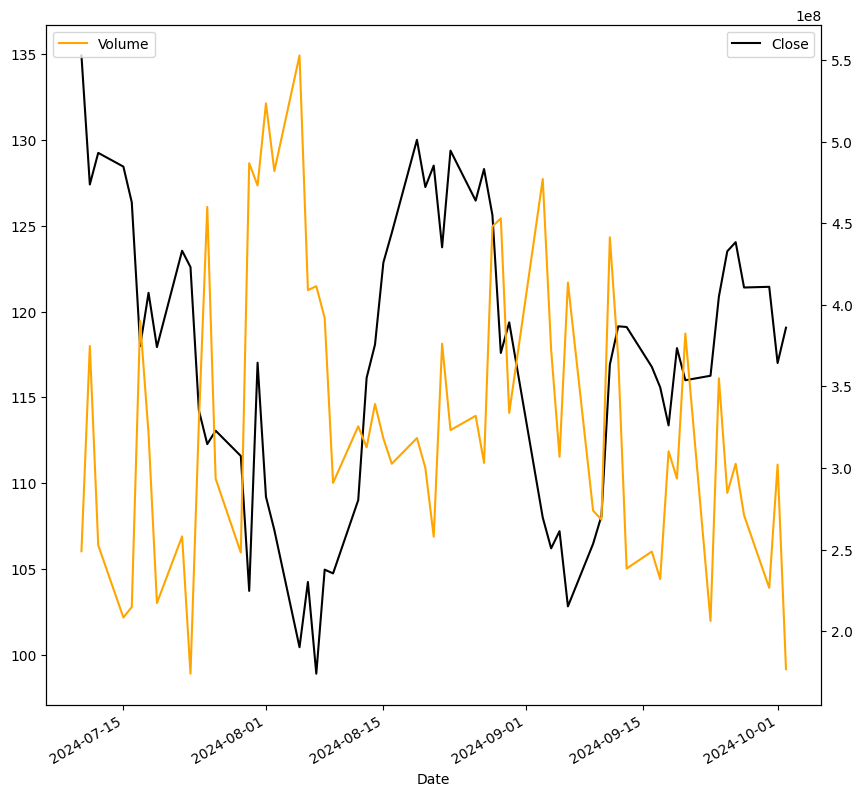

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
ticker_data['Close'][-60:].plot(ax=ax,color='black')
ax.legend()
ax2 = ax.twinx()
ticker_data['Volume'][-60:].plot(ax=ax2, color='orange', label='Volume')
# ax2.axhline(55)
ax2.legend(loc='upper left')
plt.show()



In [60]:
# np.round(review_df.sort_values(by='RSI Volume',ascending=False),2)

,Volatility,Adj Close,Week Change,1 Month Change,RSI,RSI Volume,Mean 5 day Volume,Mean 15 day Volume,Mean 30 day Volume,Mean 120 day Volume
VTYX,1.36,2.46,1.07,1.25,68.92,92.68,3434968.6,1506169.53,1451361.43,1167642.86
POET,1.37,4.40,1.43,1.44,82.65,85.86,3372906.4,1492002.13,1250754.40,1128886.93
LASE,1.96,18.80,3.44,6.53,82.76,76.23,3977604.0,2558754.67,1711710.67,1541535.17
NNE,2.56,14.17,0.93,1.36,65.50,70.57,4166898.8,3110439.60,2504573.13,2235937.83
RCAT,1.23,3.16,1.02,0.99,56.07,70.00,1538942.6,1103254.20,1175257.10,1030210.11
ORGN,1.31,1.62,1.05,1.13,58.95,64.55,2498496.8,1506405.60,1969989.47,2006357.37
DJT,1.55,12.15,0.68,0.54,28.23,58.61,14261785.4,12185555.13,8802554.23,7606723.56
WULF,1.38,4.89,1.15,1.02,67.77,58.32,22808707.2,18663709.07,19896331.20,19415320.30
SAVA,1.33,27.00,0.96,0.90,46.39,57.32,2006347.0,1529062.33,1697631.17,2232402.79
BW,1.23,1.51,1.20,1.26,87.27,56.78,1158959.4,791366.47,1051939.90,1288574.14


43.5185209713843